# OceanParcels workflow

Useful resources:

[OceanParcels Homepage](http://oceanparcels.org/)

[GMD discussion paper](https://doi.org/10.5194/gmd-2018-339)

[Coastline interaction scripts](https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts) (from GMD paper)

Source code modification (to handle WW3 longitude):

`~/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/parcels/field.py`

`@ field.py: line 1385`

`if lon.max().values > 180: lon = lon - 360`

***

In [1]:
import numpy as np
import math
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools
from IPython.display import HTML

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, Variable, ErrorCode, AdvectionRK4
from parcels import rng as random

%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['animation.html'] = 'html5'

***

## Local functions and paths

In [2]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    NEMO = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    WW3 = os.path.join(paths['ww3'], datestr[0], f'SoG_ww3_fields_{datestr[1]}.nc')
    
    return NEMO, WW3

In [3]:
def construct_unbeaching_velocities(prefix, coords, filename, speed=1):
    """https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts
    """
    
    # Load and prepare velocity arrays
    u, v = [
        xr.open_dataset(prefix + f'_grid_{vel[0]}.nc')[vel[1]].values[0, 0, ...]
        for vel in [('U', 'vozocrtx'), ('V', 'vomecrty')]
    ]
    m, n = u.shape; tol = 1e-10
    u_unBeach, v_unBeach = np.zeros((m, n)), np.zeros((m, n))

    # Fill unbeaching velocities at coastline
    for j in range(1, m-2):
        for i in range(1, n-2):
            if u[j+1, i] == 0 and u[j+1, i+1] == 0 and v[j, i+1] == 0 and v[j+1, i+1] == 0:
                if abs(u[j+1, i-1]) > tol: u_unBeach[j+1, i] = -speed
                if abs(u[j+1, i+2]) > tol: u_unBeach[j+1, i+1] = speed
                if abs(v[j-1, i+1]) > tol: v_unBeach[j, i+1] = -speed
                if abs(v[j+2, i+1]) > tol: v_unBeach[j+1, i+1] = speed

    # Export unbeaching dataset
    xr.Dataset(
        {
            'u_unBeach': (['y', 'x'], u_unBeach),
            'v_unBeach': (['y', 'x'], v_unBeach),
            'glamu': (['time', 'y', 'x'], coords.glamu),
            'gphiu': (['time', 'y', 'x'], coords.gphiu),
            'glamv': (['time', 'y', 'x'], coords.glamv),
            'gphiv': (['time', 'y', 'x'], coords.gphiv),
            'glamf': (['time', 'y', 'x'], coords.glamf),
            'gphif': (['time', 'y', 'x'], coords.gphif),
        },
        coords={'time': ('time', coords.time)},
    ).to_netcdf(filename)

In [4]:
# Define paths
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'date_cutoff': '2016 Nov 21',
    'ww3': '/opp/wwatch3/nowcast',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'out': '/data/bmoorema/results/parcels',
}
mask = xr.open_dataset(paths['mask'])
coords = xr.open_dataset(paths['coords'], decode_times=False)
#daterange = [parse(d) for d in ['2017 Nov 10', '2017 Nov 12']]
date = datetime(2019, 1, 1)
#construct_unbeaching_velocities(make_prefix(date, paths)[0], coords, paths['out'] + '/forcing/unbeaching.nc')

***

## Simulation

User-defined kernels and drifter classes

https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts

In [5]:
class Drifter(JITParticle):
    beached = Variable('beached', dtype=np.int32, initial=0.)

In [6]:
def Stokes_drift(particle, fieldset, time):
    (u_uss, v_uss) = fieldset.UVuss[time, particle.depth, particle.lat, particle.lon]
    particle.lon += u_uss * particle.dt
    particle.lat += v_uss * particle.dt

In [7]:
def Brownian_beaching(particle, fieldset, time):
    particle.beached = 0
    dx, dx0 = 500, 1000
    kh0 = 1              # 1 m2/s default, smaller values will diffuse less
    deg2m = 1.2321e10    # (111e3 m/deg)^2
    kh = kh0 / deg2m * math.pow((dx / dx0), 1.33) # Eddy lengthscale dependent kh, Stommel 1949, JMR
    offset_lon = random.uniform(-1., 1.) * math.sqrt(2 * particle.dt * kh)
    offset_lat = random.uniform(-1., 1.) * math.sqrt(2 * particle.dt * kh)
    (u, v) = fieldset.UV[time, particle.depth, particle.lat + offset_lat, particle.lon + offset_lon]
    if u == 0 and v == 0: particle.beached = 1

In [8]:
def coastline_interaction(particle, fieldset, time):
    particle.beached = 0
    (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    if u == 0 and v == 0:
        (ub, vb) = fieldset.UVunbeach[time, particle.depth, particle.lat, particle.lon]
        particle.lon += ub * particle.dt
        particle.lat += vb * particle.dt
        particle.beached = 1

In [9]:
def DeleteParticle(particle, fieldset, time):
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

Load forcing data

In [10]:
# Build filenames
NEMOin, WW3in = {'U': [], 'V': []}, []
for day in range(1, 21):
    path_NEMO, path_WW3 = make_prefix(datetime(2019, 1, day), paths)
    WW3in.append(path_WW3)
    for vel in ['U', 'V']:
        NEMOin[vel].append(path_NEMO + f'_grid_{vel}.nc')

# Load NEMO forcing
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'data': NEMOin['U']},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'data': NEMOin['V']},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
field_set = FieldSet.from_nemo(filenames, variables, dimensions)

         It will be opened with no decoding. Filling values might be wrongly parsed.


Load ancillary forcing data

In [ ]:
# Load WW3 Stokes drift
#dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
#Uuss = Field.from_netcdf(WW3in, ('Uuss', 'uuss'), dimensions, fieldtype='U')
#Vuss = Field.from_netcdf(WW3in, ('Vuss', 'vuss'), dimensions, fieldtype='V', grid=Uuss.grid, dataFiles=Uuss.dataFiles)
#field_set.add_field(Uuss)
#field_set.add_field(Vuss)
#field_set.add_vector_field(VectorField('UVuss', field_set.Uuss, field_set.Vuss))

# Load unbeaching velocities
#filenames = paths['out'] + '/forcing/unbeaching.nc'
#variables = {'Uunbeach': 'u_unBeach', 'Vunbeach': 'v_unBeach'}
#dimensions = {'lon': 'glamf', 'lat': 'gphif'}
#field_set_unbeach = FieldSet.from_nemo(filenames, variables, dimensions, tracer_interp_method='cgrid_velocity')
#field_set.add_field(field_set_unbeach.Uunbeach)
#field_set.add_field(field_set_unbeach.Vunbeach)
#field_set.add_vector_field(VectorField('UVunbeach', field_set.Uunbeach, field_set.Vunbeach))

Run simulation

In [11]:
# Initialize particles
np.random.seed(0); random = 0.01 * np.random.rand(100)
pset = ParticleSet.from_list(field_set, Drifter, lon=random-123.28, lat=random+49.46)

# Define behavior kernels
kernel = pset.Kernel(AdvectionRK4) # + pset.Kernel(Brownian_beaching)

# Execute simulation
outfile = os.path.join(paths['out'], 'results', 'nobeaching.nc')
pset.execute(
    kernel, runtime=timedelta(days=19), dt=90,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled DrifterAdvectionRK4 ==> /tmp/parcels-1896/d9c95ed5f4d05f40a97f58ef3f29c54c.so
100% (1641600.0 of 1641600.0) |##########| Elapsed Time: 0:05:11 Time:  0:05:11


***

## Results

In [13]:
%%capture

data, line, beach = {}, {}, {}

flags = ['nobeaching', 'beaching']
for flag in flags:
    data[flag] = xr.open_dataset(os.path.join(paths['out'], 'results', f'{flag}.nc'))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, flag in zip(axs, flags):
    ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([-124.8, -123.1])
    ax.set_ylim([49.2, 50.1])
    ax.set_title(flag)
    viz_tools.set_aspect(ax)
    line[flag], = ax.plot([], [], 'ko', zorder=0)
    beach[flag], = ax.plot([], [], 'ro', zorder=1)

def animate(hour):
    for flag in flags:
        ibeach = data[flag].beached[:, hour] == 1
        line[flag].set_data(data[flag].lon[~ibeach, hour], data[flag].lat[~ibeach, hour])
        beach[flag].set_data(data[flag].lon.values[ibeach, hour], data[flag].lat.values[ibeach, hour])
        
    return (line[flag],), (beach[flag],)

anim = animation.FuncAnimation(fig, animate, frames=455, interval=100)

In [14]:
HTML(anim.to_html5_video())

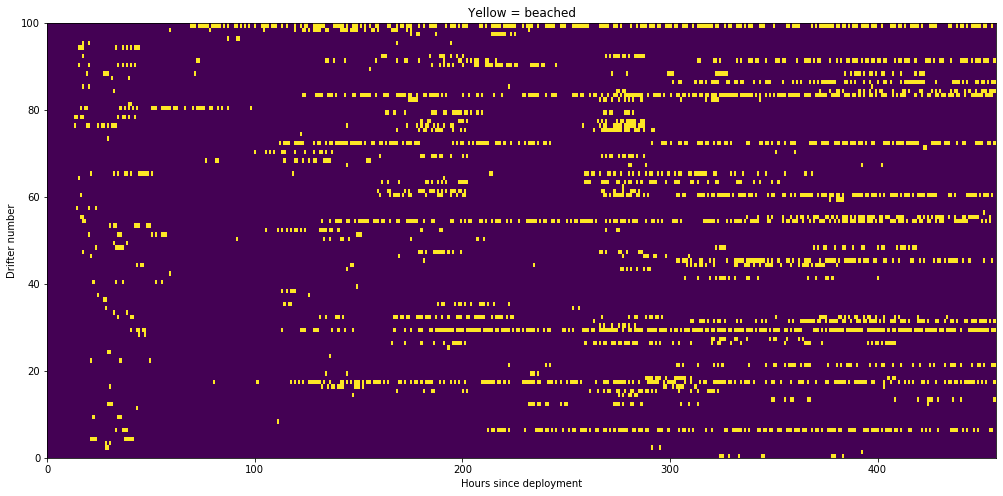

In [15]:
fig, ax = plt.subplots(figsize=(17, 8))
ax.pcolormesh(data['beaching'].beached)
ax.set_xlabel('Hours since deployment')
ax.set_ylabel('Drifter number')
ax.set_title('Yellow = beached')
plt.show()